In [1]:
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.io as pio
import plotly.graph_objects as go

from collections import defaultdict
from pathlib import Path
import pandas as pd
import numpy as np
from typing import *

import statsmodels
import statsmodels.api as sm
from statsmodels.othermod.betareg import BetaModel
from sklearn.neighbors import KNeighborsRegressor
import scipy.stats as stats
from scipy.stats import boxcox
from scipy.special import inv_boxcox

import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.feature_selection import RFECV
from sklearn.model_selection import KFold

from sklearn.model_selection import train_test_split
from sklearn.metrics import *

pio.renderers.default = "iframe"

In [23]:
# base_path = "/data/saturation/random_runs_20230812"
base_path = "/data/saturation/ir_random_1"

ivs = [
    "slope",
    "effective_radius_multiplier",
    "r_stat_multiplier",
    "min_rim_percentage",
    "z",
    "za",
    "n_craters_in_study_region",
    "areal_density",
    "areal_density_overlap_2",
    "areal_density_overlap_3",
    "center_to_center_nearest_neighbor_distance_mean",
    "center_to_center_nearest_neighbor_distance_stdev",
    "center_to_center_nearest_neighbor_distance_min",
    "center_to_center_nearest_neighbor_distance_max",
    "radius_mean",
    "radius_stdev"
]

non_constant_ivs = [
    "z",
    "za",
    "areal_density",
    "areal_density_overlap_2",
    "areal_density_overlap_3",
    "center_to_center_nearest_neighbor_distance_mean",
    "center_to_center_nearest_neighbor_distance_stdev",
    "center_to_center_nearest_neighbor_distance_min",
    "center_to_center_nearest_neighbor_distance_max",
    "radius_mean",
    "radius_stdev"
]

In [24]:
def fix_up_df(df: pd.DataFrame):
    df["z"] = df.z.fillna(0)
    df["za"] = df.za.fillna(0)
    df["log_n_craters_added_in_study_region"] = np.log10(df.n_craters_added_in_study_region)
    df["craters_removed"] = df.n_craters_added_in_study_region - df.n_craters_in_study_region
    df["log_craters_removed"] = np.log10(1 + df.craters_removed)
    for x in ivs:
        df[f"log_{x}"] = np.log10(1 + df[x])
    return df

In [25]:
sample_size = 50

train_df = pd.read_parquet(f"{base_path}/train_{sample_size}.parquet")
train_df = fix_up_df(train_df)

test_df = pd.read_parquet(f"{base_path}/test_{sample_size}.parquet")
test_df = fix_up_df(test_df)

metric = "log_craters_removed"

/home/mason/code/saturation/venv_311/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning:

invalid value encountered in log10

/home/mason/code/saturation/venv_311/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning:

invalid value encountered in log10

/home/mason/code/saturation/venv_311/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning:

invalid value encountered in log10

/home/mason/code/saturation/venv_311/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning:

invalid value encountered in log10



In [26]:
metric = "log_craters_removed"

transform = lambda x: x
inverse_transform = lambda x: x
# inverse_transform = lambda x: 10**x

features = [
    "slope",
    "log_center_to_center_nearest_neighbor_distance_mean",
    # "areal_density",
    # "areal_density_overlap_2",
    # "log_n_craters_in_study_region"
]

xtr = train_df[train_df.n_craters_in_study_region > 100].reset_index().copy()
xte = test_df[test_df.n_craters_in_study_region > 100].reset_index().copy()

X_train = xtr[features]
X_test = xte[features]

y_train = transform(xtr[metric])
y_test = transform(xte[metric])

standard_scaler = sklearn.preprocessing.StandardScaler()
X_train = standard_scaler.fit_transform(X_train)
X_train = pd.DataFrame(X_train, columns=standard_scaler.get_feature_names_out())

poly_transform = sklearn.preprocessing.PolynomialFeatures(degree=1, include_bias=False)
X_train = poly_transform.fit_transform(X_train)
X_train = pd.DataFrame(X_train, columns=poly_transform.get_feature_names_out())
X_train.log_center_to_center_nearest_neighbor_distance_mean = X_train.log_center_to_center_nearest_neighbor_distance_mean / 2

X_test = pd.DataFrame(standard_scaler.transform(X_test), columns=standard_scaler.get_feature_names_out())
X_test = poly_transform.transform(X_test)
X_test = pd.DataFrame(X_test, columns=poly_transform.get_feature_names_out())
X_test.log_center_to_center_nearest_neighbor_distance_mean = X_test.log_center_to_center_nearest_neighbor_distance_mean / 2


model = KNeighborsRegressor(n_neighbors=25, n_jobs=24, weights="distance", metric="euclidean").fit(X_train, y_train)

y_pred = inverse_transform(model.predict(X_test))
yt = inverse_transform(y_test)
pred_df = X_test.copy()
pred_df["prediction"] = yt

rmse = mean_squared_error(y_pred, yt, squared=False)
mape = mean_absolute_percentage_error(yt, y_pred)
mae = mean_absolute_error(y_pred, yt)
print(f"RMSE: {rmse:.4f}, Train MAE: {mae:.4f}, Train MAPE: {mape:.4f}")

y_pred = [inverse_transform(y_train.mean())] * y_test.shape[0]
yt = inverse_transform(y_test)

rmse = mean_squared_error(y_pred, yt, squared=False)
mape = mean_absolute_percentage_error(yt, y_pred)
mae = mean_absolute_error(y_pred, yt)
print(f"RMSE: {rmse:.4f}, Train MAE: {mae:.4f}, Train MAPE: {mape:.4f}")

RMSE: 0.6854, Train MAE: 0.5367, Train MAPE: 8476557109018.4434
RMSE: 1.1975, Train MAE: 0.9331, Train MAPE: 315922628573324.6250


In [28]:
metric = "log_craters_removed"

transform = lambda x: x
# inverse_transform = lambda x: x
inverse_transform = lambda x: 10**x

features = [
    "slope",
    "log_center_to_center_nearest_neighbor_distance_mean",
    # "areal_density",
    # "areal_density_overlap_2",
    "log_n_craters_in_study_region"
]

xtr = train_df[train_df.n_craters_in_study_region > 100].reset_index().copy()
xte = test_df[test_df.n_craters_in_study_region > 100].reset_index().copy()

X_train = xtr[features]
X_test = xte[features]

y_train = transform(xtr[metric])
y_test = transform(xte[metric])

standard_scaler = sklearn.preprocessing.StandardScaler()
X_train = standard_scaler.fit_transform(X_train)
X_train = pd.DataFrame(X_train, columns=standard_scaler.get_feature_names_out())

poly_transform = sklearn.preprocessing.PolynomialFeatures(degree=1, include_bias=False)
X_train = poly_transform.fit_transform(X_train)
X_train = pd.DataFrame(X_train, columns=poly_transform.get_feature_names_out())
X_train.log_center_to_center_nearest_neighbor_distance_mean = X_train.log_center_to_center_nearest_neighbor_distance_mean / 4

X_test = pd.DataFrame(standard_scaler.transform(X_test), columns=standard_scaler.get_feature_names_out())
X_test = poly_transform.transform(X_test)
X_test = pd.DataFrame(X_test, columns=poly_transform.get_feature_names_out())
X_test.log_center_to_center_nearest_neighbor_distance_mean = X_test.log_center_to_center_nearest_neighbor_distance_mean / 4


model = KNeighborsRegressor(n_neighbors=25, n_jobs=24, weights="distance", metric="euclidean").fit(X_train, y_train)

y_pred = inverse_transform(model.predict(X_test))
yt = inverse_transform(y_test)
pred_df = X_test.copy()
pred_df["prediction"] = yt

rmse = mean_squared_error(y_pred, yt, squared=False)
mape = mean_absolute_percentage_error(yt, y_pred)
mae = mean_absolute_error(y_pred, yt)
print(f"RMSE: {rmse:.4f}, Train MAE: {mae:.4f}, Train MAPE: {mape:.4f}")

y_pred = [inverse_transform(y_train.mean())] * y_test.shape[0]
yt = inverse_transform(y_test)

rmse = mean_squared_error(y_pred, yt, squared=False)
mape = mean_absolute_percentage_error(yt, y_pred)
mae = mean_absolute_error(y_pred, yt)
print(f"RMSE: {rmse:.4f}, Train MAE: {mae:.4f}, MAPE: {mape:.4f}")

RMSE: 110428.8613, Train MAE: 42565.0386, Train MAPE: 1.0548
RMSE: 117244.5606, Train MAE: 45168.0343, MAPE: 136.5811


In [20]:
pred_df = xte.copy()
pred_df["predicted"] = inverse_transform(model.predict(X_test))
pred_df["resid"] = inverse_transform(model.predict(X_test)) - inverse_transform(pred_df[metric])

slope                          2.444887
effective_radius_multiplier    1.282611
min_rim_percentage             0.430894
Name: 0, dtype: float64


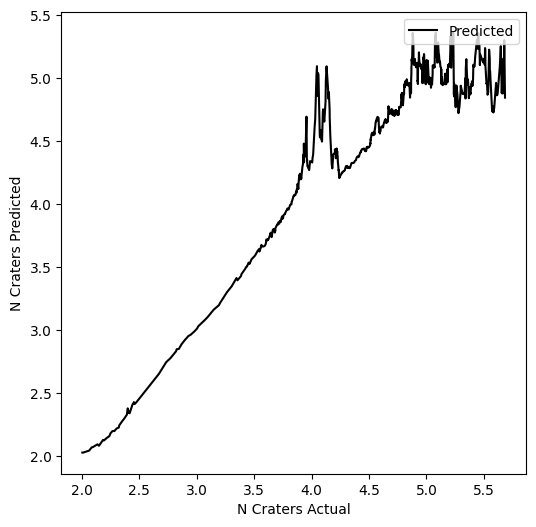

slope                          1.465672
effective_radius_multiplier    1.484714
min_rim_percentage             0.625771
Name: 50, dtype: float64


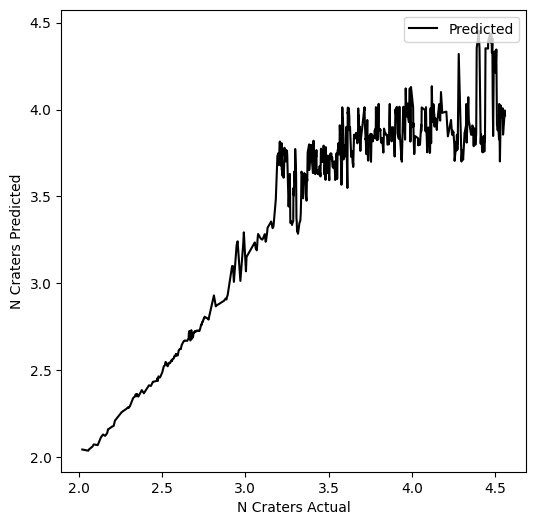

slope                          2.805113
effective_radius_multiplier    1.884478
min_rim_percentage             0.250041
Name: 100, dtype: float64


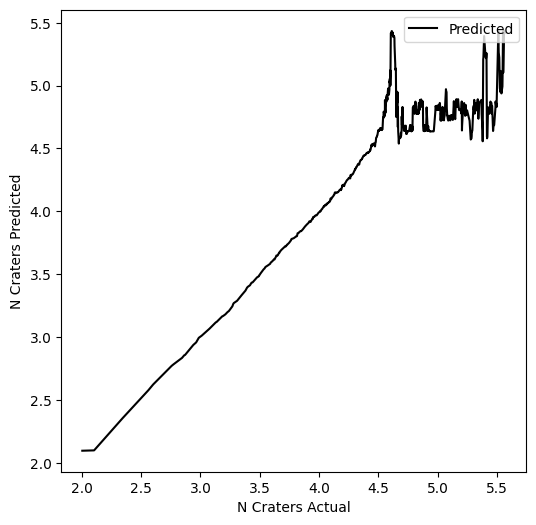

slope                          1.607999
effective_radius_multiplier    1.723657
min_rim_percentage             0.670446
Name: 150, dtype: float64


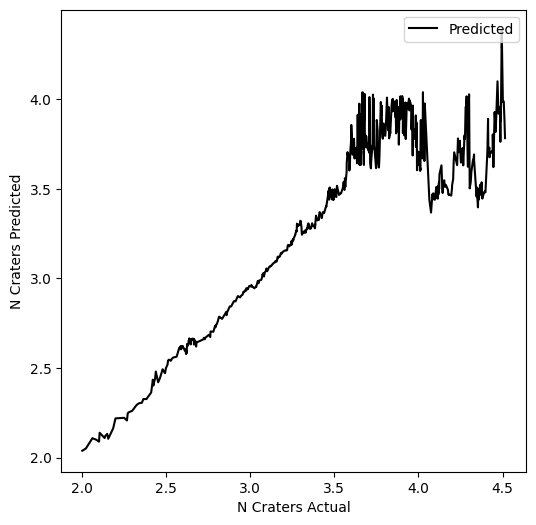

slope                          1.907369
effective_radius_multiplier    1.641525
min_rim_percentage             0.304169
Name: 200, dtype: float64


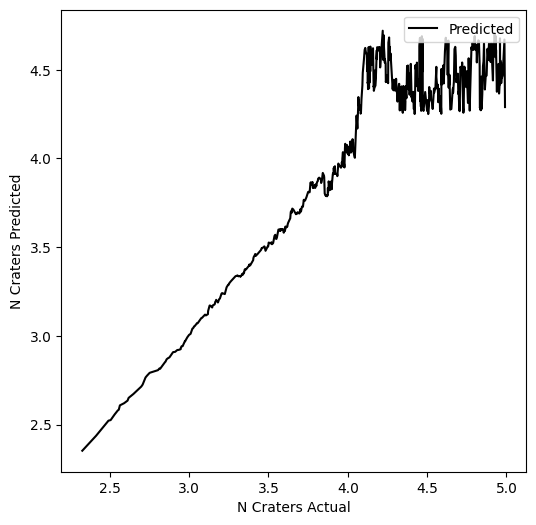

slope                          1.849374
effective_radius_multiplier    1.205190
min_rim_percentage             0.265606
Name: 250, dtype: float64


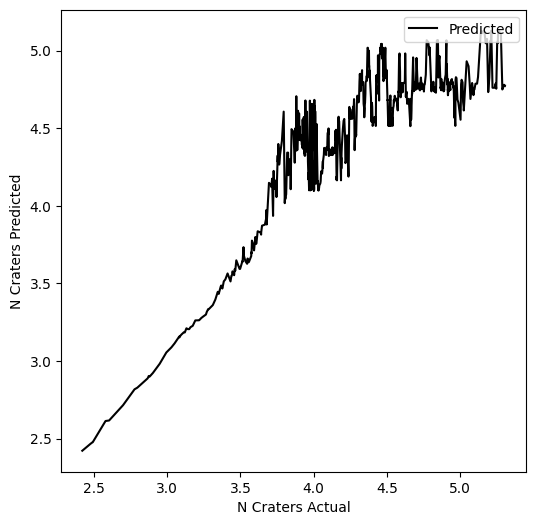

slope                          2.343890
effective_radius_multiplier    1.868235
min_rim_percentage             0.743494
Name: 300, dtype: float64


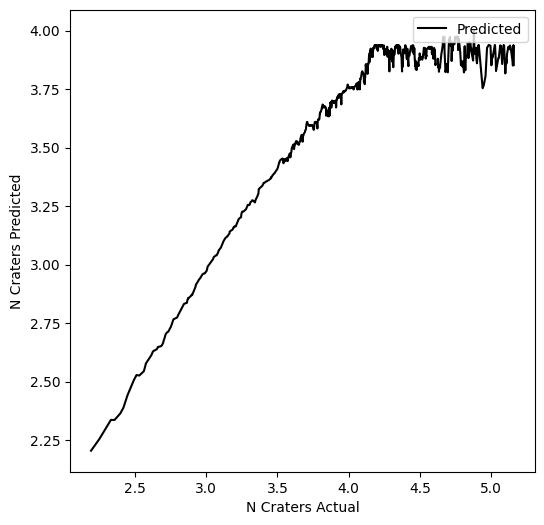

slope                          1.543287
effective_radius_multiplier    1.610255
min_rim_percentage             0.381079
Name: 350, dtype: float64


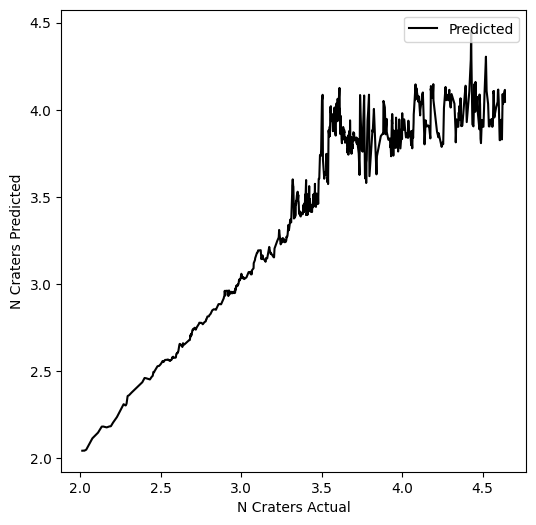

slope                          1.647850
effective_radius_multiplier    1.387136
min_rim_percentage             0.421662
Name: 400, dtype: float64


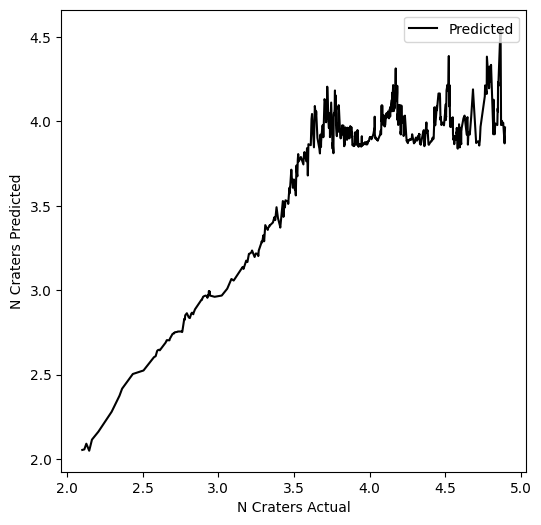

slope                          1.347250
effective_radius_multiplier    1.770975
min_rim_percentage             0.520122
Name: 450, dtype: float64


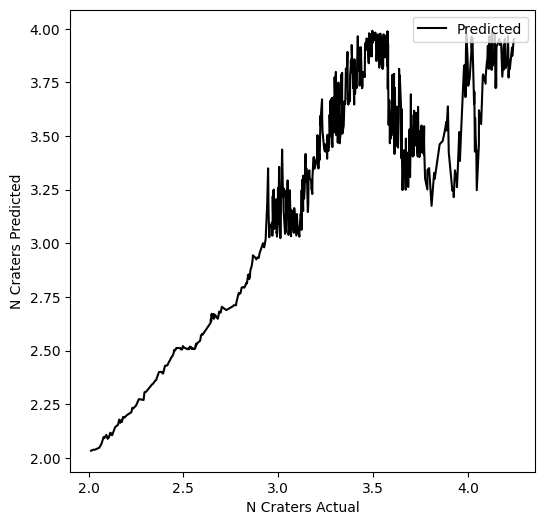

In [21]:
simulation_ids = list(pred_df.simulation_id.unique())

for x in simulation_ids[:10]:
    df = pred_df[pred_df.simulation_id == x].copy()
    print(df.iloc[0][["slope", "effective_radius_multiplier", "min_rim_percentage"]])
    df = df.sort_values("n_craters_added_in_study_region")
    
    fig = plt.figure(figsize=(6, 6))
    ax1 = fig.add_subplot(111)
    
    plt1 = ax1.plot(inverse_transform(df[metric]), df.predicted, color='black', label="Predicted")
    ax1.set_xlabel("N Craters Actual")
    ax1.set_ylabel("N Craters Predicted")
    
    lns = plt1
    ax1.legend(lns, [l.get_label() for l in lns], loc=1)
    
    plt.show()